In [22]:
import time 
import os
import numpy as np
import pandas as pd
import pylab as pl
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from fft_conv_pytorch import fft_conv, FFTConv1d
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Helper Functions

## Plotter Functions

In [2]:
def plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):
    n_fft = len(matchedFilter)
    f = np.arange(0,fs/2,fs/n_fft)
    w = np.hanning(len(matchedFilter))
    mf_freqDom = np.fft.fft(np.multiply(matchedFilter,w))
    mf_freqDom = 20*np.log10(np.abs(mf_freqDom[0:int(n_fft/2)]/n_fft))
    pl.subplot(3,1,1)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],m[0:int(fs*bitsPerWord*minbit)])
    pl.xlabel("Time (s)")
    pl.ylabel("Frequency (Hz)")
    pl.title("Original VCO output verus time")
    pl.grid = True
    pl.subplot(3,1,2)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],matchedFilter[0:int(fs*bitsPerWord*minbit)])
    pl.xlabel("Time (s)")
    pl.ylabel("Amplitude (V)")
    pl.title("Original of carrier verus time")
    pl.grid = True
    pl.subplot(3,1,3)
    pl.plot(f[0:int((fc+fdev*2)*n_fft/fs)],matchedFilter[0:int((fc+fdev*2)*n_fft/fs)])
    pl.xlabel("Frequency (Hz)")
    pl.ylabel("Amplitude (dB)")
    pl.title("Spectrum")
    pl.grid = True
    pl.tight_layout()
    pl.show
    
def plot_spectral(fft_size, signal, fs):
    print(signal.shape)
    num_rows = int(np.floor(len(signal)/fft_size))
    spectrogram = np.zeros((num_rows, fft_size))
    for i in range(num_rows):
        spectrogram[i,:] = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal[i*fft_size:(i+1)*fft_size])))**2)
    spectrogram = spectrogram[:,fft_size//2:] # get rid of negative freqs because we simulated a real signal
    plt.rcParams["figure.figsize"] = (15,15)
    plt.imshow(spectrogram, aspect="auto", extent = [0, fs/2/1e6, len(signal)/fs*1e-6, 0])
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Time [us]")
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    plt.show()
    #plt.savefig('../_images/spectrogram.svg', bbox_inches='tight')

## Signal Generation Helpers

In [3]:
def noise_spectrum(lowRF, highRF, numSamples):
    noiseCarrierFreqs = np.random.uniform(low=lowRF, high=highRF, size=numSamples)
    return noiseCarrierFreqs

def make_pulse_train(train, matchedFilter, pw, pri, fs, lowRF, highRF, noiseAmp):
    interpTime = pri-pw
    noiseCarrierFreqs = noise_spectrum(lowRF, highRF, int(interpTime/(1/fs)))
    pads = noiseAmp*np.random.random(size=int(interpTime/(1/fs)))*np.exp(1j*2*np.pi*noiseCarrierFreqs*int(interpTime/(1/fs)))
    mfNoise = np.random.random(size=len(matchedFilter))*noiseAmp
    matchedFilter += mfNoise
    matchedFilter = matchedFilter - np.mean(matchedFilter) # removes DC componenet introduced by adding noise, while preserving noise on pulses
    train_add = np.hstack((matchedFilter, pads.real))
    new_train = np.hstack((train, train_add))
    return new_train

def upsample(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out
    
def make_FM_pulse(A, fc, cr, t):
    fmPulse = A*np.exp(1j*np.pi*cr*t*t)*np.exp(1j*2*np.pi*fc*t)
    return fmPulse

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(np.arange(0,len(sync))*1/fs+np.pi*sync)))
    return bpskPulse

def make_FSK_pulse(A,code,minbit,fs,fc,fdev,ctrlBit):
    sync = upsample(code, fs*minbit)
    t = np.arange(0,len(sync))*1/fs
    m = []
    for bit in sync:
        if bit == ctrlBit:
            m = np.hstack((m, (fc-fdev)))
        else:
            m = np.hstack((m, (fc+fdev)))              
    fskPulse = A*np.exp(1j*(2*np.pi*np.multiply(m,t)))
    return fskPulse     

## Convolution Signal Functioons

In [4]:
def complex_matmul(signal, filterBank):
    """Multiplies two complex-valued tensors."""
    # Scalar matrix multiplication of two tensors, over only the first two dimensions.
    # Dimensions 3 and higher will have the same shape after multiplication.
    scalar_matmul = partial(torch.einsum, "ab..., cb... -> ac...")

    # Compute the real and imaginary parts independently, then manually insert them
    # into the output Tensor.  This is fairly hacky but necessary for PyTorch 1.7.0,
    # because Autograd is not enabled for complex matrix operations yet.  Not exactly
    # idiomatic PyTorch code, but it should work for all future versions (>= 1.7.0).
    real = scalar_matmul(signal.real, b.real) - scalar_matmul(signal.imag, filterBank.imag)
    imag = scalar_matmul(signal.imag, b.real) + scalar_matmul(signal.real, filterBank.imag)
    c = torch.zeros(real.shape, dtype=torch.complex64)
    c.real, c.imag = real, imag

    return c

def cmplxCnv(signal, filterBank):
    iData = signal.real # Transform into freq domain and then do multiplication, then ifft back and recombine
    qData = signal.imag
    iFilters = filterBank.real
    qFilters = filterBank.imag
    
    iOut = nn.Conv1d(iData,iFilters)
    qOut = nn.Conv1d(qData,qFilters)
    return torch.complex(iOut,qOut)

# Pytorch Classes & Functions

In [59]:
class FilterBank(nn.Module):
    def __init__(self,input_channel,num_filters,filter_length,weights = None,stride = 1,norm = None):
        super().__init__()
        self.conv = nn.Conv1d(input_channel,num_filters,filter_length,padding = 0,stride = stride,bias = False)

    def forward(self, x):
        output = self.conv(x)
        return output
    
def init_process(rank, size, backend='nccl'):
    os.environ["MASTER_ADDR"] = "192.168.1.174"
    os.environ["MASTER_PORT"] = "30000"
    dist.init_process_group(backend = backend,
                            init_method ="env://",
                            world_size = size,
                            rank = rank
                           )

class SigData(Dataset):
    def __init__(self, data, fs):
        self.x_delta = 1/fs # define sample time between points
        self.data = data
    def __getitem__(self, index):
        data = self.data.cpu().numpy()
        x = torch.from_numpy(data.reshape((1, -1))).float()
        y = torch.arange(0, len(data))
        return x, y, index
    def __len__(self):
        return int(self.size)

def db_transform(x):
    x = torch.abs(x)
    m = torch.mean(x)
    return 20 * torch.log10(x / m)

def z_transform(x):
    m = torch.mean(x, 2).unsqueeze_(2)
    s = torch.std(x, 2).unsqueeze_(2)
    return torch.abs((x - m) / s )

# Generate signal first

ValueError: Unrecognized character 0 in format string

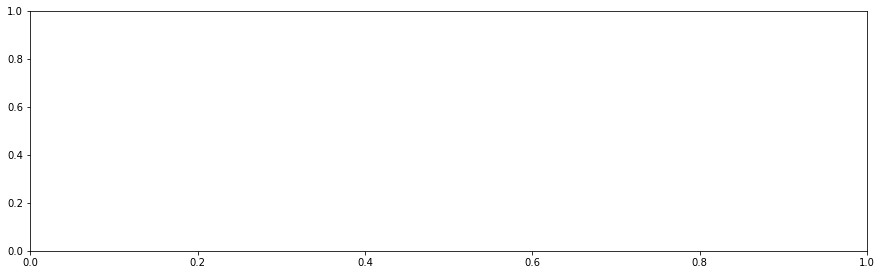

In [66]:
words = pd.read_csv("/Users/cgzog/Python_Projects/allPossible8bitWords.csv",dtype=str)      
randCodes = words.sample(n=5)
pri = 1e-3*np.ones(len(randCodes))
rf = 40e6*np.ones(len(randCodes))
bitrate = 8e6*np.ones(len(randCodes))
pw = 8/bitrate*np.ones(len(randCodes))

m = []
for code in randCodes.Code:
    m.append(code)
    
df = pd.DataFrame({"PD (usec)": pw, "PRI (usec)": pri, "RF (MHz)": rf, "Code": m}).to_csv("pulseTrainTest.csv")

test = pd.read_csv("pulseTrainTest.csv",dtype={"Code":str})
pdArray =  test["PD (usec)"]
priArray = test["PRI (usec)"]
RF = test["RF (MHz)"]
#test = pd.read_csv("pulseTrainTest.csv",dtype=str)
code = test["Code"]

A = 100
pd_idx = np.arange(0,len(pdArray))
start = time.time()
idx = 0
fs = 500e6
fc = 40e6
pri = 1e-3
noiseAmp = 15
bitrate = 8e6
pw = 8/bitrate
lowRF = 0
highRF = 250e6
while idx < test.shape[0]:
    t = np.arange(-pw/2, pw/2, 1/fs)
    pulse = make_BPSK_pulse(A, code[idx], fs, fc, 1/bitrate)  # decide later
    #def plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):
    plot_data(pulse,fs,1/bitrate,8,code[idx],fc,0)
    if idx == 0:
        train = make_pulse_train([], pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    if idx > 0:
        train = make_pulse_train(train, pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    idx += 1

In [9]:
signal = torch.zeros([1,1,len(train)],dtype=torch.cfloat)
signal[0,0,:] = torch.complex(torch.tensor(train.real),torch.tensor(train.imag))
signal.size()

torch.Size([1, 1, 2500000])

# Plot Raw Signal

(2500000,)


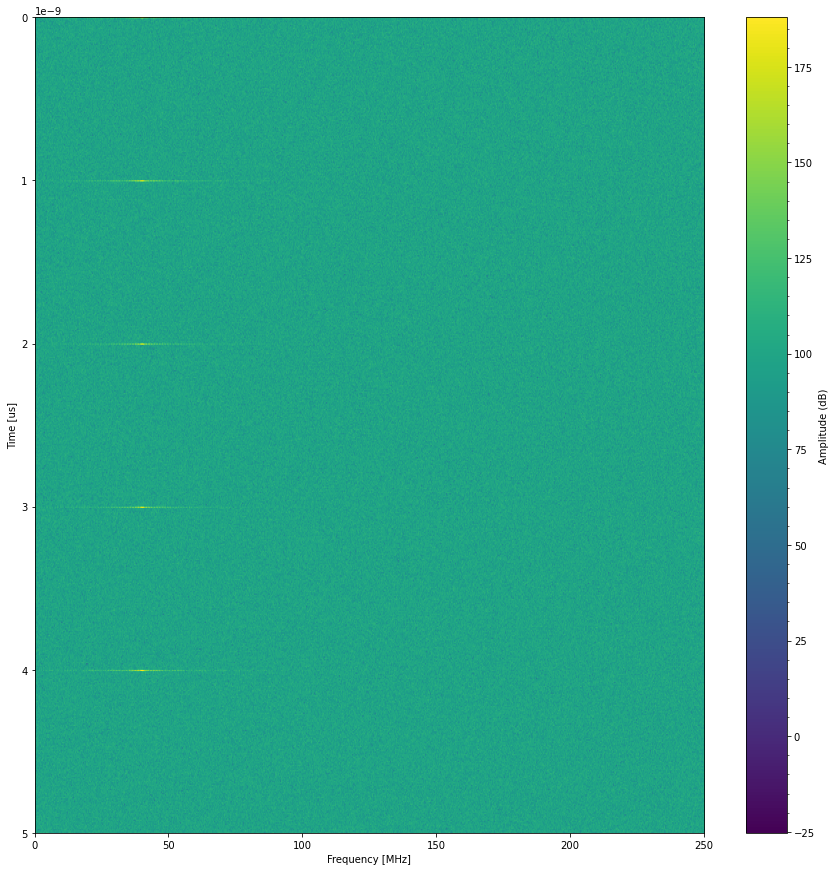

In [10]:
plot_spectral(2**12, train, fs)

# Create Filters

In [11]:
words = pd.read_csv("/Users/cgzog/Python_Projects/allPossible8bitWords.csv",dtype=str)
fs = 500e6
bitrate = 8e6
A = 100
fc = 40e6
pw = 8/bitrate
t = np.arange(-pw/2, pw/2, 1/fs)
filterBank = torch.zeros([words.shape[0],1,len(t)],dtype=torch.cfloat)
for index,row in words.iterrows():
    pulse = make_BPSK_pulse(A, words.Code[idx], fs, fc, 1/bitrate)  # decide later
    complexPulse = torch.complex(torch.tensor(pulse.real),torch.tensor(pulse.imag))
    filterBank[index,0,:] = complexPulse

In [ ]:
#plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):


# Convolve signal with filters

In [45]:
rank = 0
world_size = 1
cpu_only = True
if torch.cuda.is_available() and not cpu_only:
    print("I found a gpu!")
    device = torch.device("cuda", rank)
    init_process(rank, world_size, "nccl")
    device_ids = [rank]
    output_device = rank
else:
    print("No gpu found")
    device = torch.device("cpu")
    init_process(rank, world_size, "gloo")
    device_ids = None
    output_device = None

No gpu found


In [65]:
indices[0],values[:, 2]

(tensor([0]),
 tensor([      1,       2,       3,  ..., 2470603, 2477575, 2496190]))

In [62]:
imodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.real)
qmodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.imag)

detection=z_transform
threshold=4
stride = 1
end = -1

iData = SigData(signal.real, fs)
qData = SigData(signal.imag, fs)
idist_sampler = DistributedSampler(signal.real, shuffle=False)
qdist_sampler = DistributedSampler(signal.imag, shuffle=False)
iDataloader = DataLoader(iData, batch_size=1, shuffle=False, sampler=idist_sampler)
qDataloader = DataLoader(qData, batch_size=1, shuffle=False, sampler=qdist_sampler)

imodel = imodel.to(device)
for inputs, indices, index in iDataloader:
    with torch.no_grad():
        inputs = inputs.to(device)
        indices = indices.to(device)
        outputs = imodel(inputs)
        end = int(outputs.shape[-1] * stride)
        indices = indices[:, :end:stride]
        outputs = detection(outputs)
        mask = outputs.ge(threshold)
        values = torch.nonzero(mask)
    outputs = outputs[values[:, 0], values[:, 1], values[:, 2]].data.cpu().numpy()
    filters = values[:, 1].data.cpu().numpy()
    indices = indices[0][values[:, 2]].data.cpu().numpy()
    toa = indices * 1/fs

iOut = pd.DataFrame({"TOA": toa, "Correlation": outputs, "Filters": filters})

qmodel = qmodel.to(device)
for inputs, indices, index in qDataloader:
    with torch.no_grad():    
        inputs = inputs.to(device)
        indices = indices.to(device)
        outputs = qmodel(inputs)
        end = int(outputs.shape[-1] * stride)
        indices = indices[:, :end:stride]
        outputs = detection(outputs)
        mask = outputs.ge(threshold)
        values = torch.nonzero(mask)
    outputs = outputs[values[:, 0], values[:, 1], values[:, 2]].data.cpu().numpy()
    filters = values[:, 1].data.cpu().numpy()
    indices = indices[0][values[:, 2]].data.cpu().numpy()
    toa = indices * 1/fs

qOut = pd.DataFrame({"TOA": toa, "Correlation": outputs, "Filters": filters})

IndexError: index 1500126 is out of bounds for dimension 0 with size 1

In [35]:
iOut = iOut[iValues[:, 0], iValues[:, 1], iValues[:, 2]].data.cpu().numpy()
iFilters = iValues[:, 1].data.cpu().numpy()

qOut = qOut[qValues[:, 0], qValues[:, 1], qValues[:, 2]].data.cpu().numpy()
qFilters = qValues[:, 1].data.cpu().numpy()

In [36]:
justForNow = iOut
mfSignal = iOut + 1j*qOut # real and imag convolution return different lengths?

ValueError: operands could not be broadcast together with shapes (643278,) (970845,) 

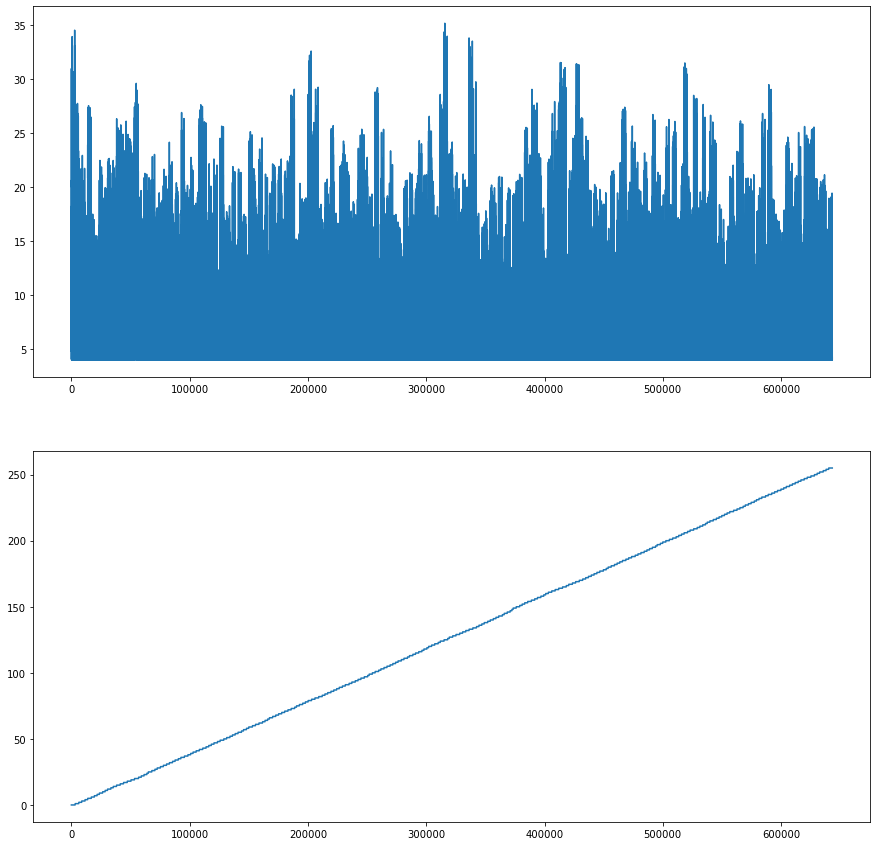

In [44]:
plt.subplot(2,1,1)
plt.plot(np.arange(0,len(justForNow)),justForNow)

plt.subplot(2,1,2)
plt.plot(np.arange(0,len(justForNow)),iFilters)